## 1️⃣ Install Dependencies

In [ ]:
# Install ultralytics (YOLOv8) and other required packages
!pip install -q ultralytics>=8.0.0
!pip install -q albumentations>=1.3.0
!pip install -q scikit-learn>=1.0.0
!pip install -q seaborn>=0.12.0
!pip install -q grad-cam>=1.4.0

print("✅ Installation complete!")

In [1]:
# Import libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

# Ultralytics YOLOv8
from ultralytics import YOLO

# sklearn for metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_curve, auc
)
from sklearn.model_selection import train_test_split

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✅ Libraries imported!")
print(f"Working directory: {os.getcwd()}")

✅ Libraries imported!
Working directory: c:\Users\bened\Downloads\sharon miss project


## 2️⃣ Configuration

In [ ]:
# ============== CONFIGURATION ==============
# Update these paths based on your dataset location

# For Kaggle:
# DATA_DIR = Path("/kaggle/input/crack-detection/dataset")
# OUTPUT_DIR = Path("/kaggle/working")

# For Google Colab or Local:
DATA_DIR = Path("./dataset")  # Your dataset folder with class subfolders
OUTPUT_DIR = Path("./output")

# Training configuration
CONFIG = {
    # Model selection: 'yolov8n-cls', 'yolov8s-cls', 'yolov8m-cls', 'yolov8l-cls'
    'model': 'yolov8s-cls',  # Using Small model for better accuracy (target >92%)
    
    # Training parameters
    'epochs': 100,          # More epochs for better convergence
    'batch_size': 16,       # Smaller batch for better generalization
    'img_size': 224,        # Image size
    'patience': 15,         # Early stopping patience
    
    # Learning rate
    'lr0': 0.001,           # Lower initial LR for fine-tuning pretrained model
    'lrf': 0.01,            # Final learning rate (lr0 * lrf)
    
    # Data split
    'val_split': 0.15,      # Validation split ratio
    'test_split': 0.10,     # Test split ratio
    
    # Augmentation (YOLOv8 built-in)
    'augment': True,
    'hsv_h': 0.015,         # HSV-Hue augmentation
    'hsv_s': 0.4,           # HSV-Saturation augmentation
    'hsv_v': 0.4,           # HSV-Value augmentation
    'degrees': 10.0,        # Rotation (+/- deg)
    'translate': 0.1,       # Translation (+/- fraction)
    'scale': 0.2,           # Scale (+/- gain)
    'shear': 5.0,           # Shear (+/- deg)
    'flipud': 0.5,          # Flip up-down probability
    'fliplr': 0.5,          # Flip left-right probability
    'mosaic': 0.0,          # Mosaic augmentation (0 for classification)
    'mixup': 0.1,           # Mixup augmentation probability
    'erasing': 0.2,         # Random erasing probability
}

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("📋 Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

📋 Configuration:
  model: yolov8n-cls
  epochs: 50
  batch_size: 32
  img_size: 224
  patience: 10
  lr0: 0.01
  lrf: 0.01
  val_split: 0.15
  test_split: 0.1
  augment: True
  hsv_h: 0.015
  hsv_s: 0.4
  hsv_v: 0.4
  degrees: 10.0
  translate: 0.1
  scale: 0.2
  shear: 5.0
  flipud: 0.5
  fliplr: 0.5
  mosaic: 0.0
  mixup: 0.1
  erasing: 0.2


## 3️⃣ Dataset Exploration & Preparation

📂 Dataset directory: dataset
📊 Found 2 classes:
  • crack: 570 images
  • without_crack: 574 images

📈 Total images: 1144


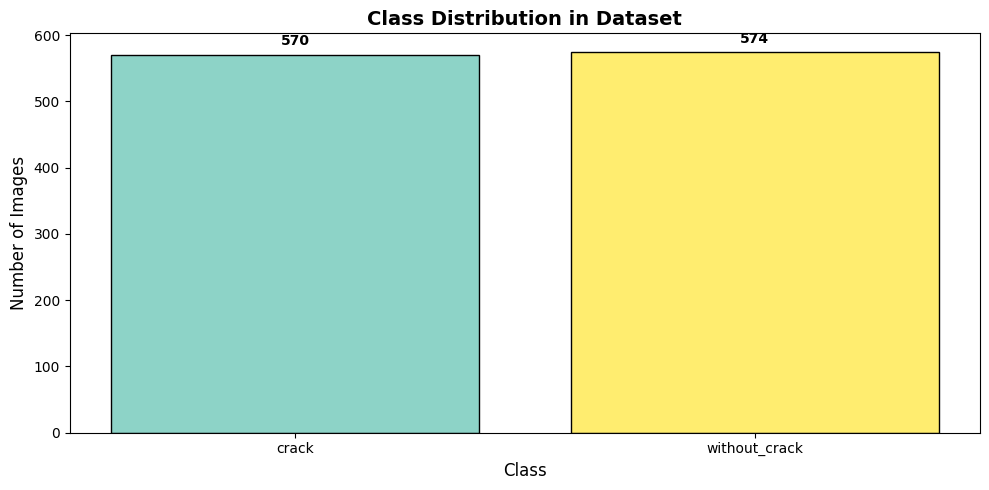

In [3]:
def explore_dataset(data_dir):
    """Explore the dataset structure and class distribution."""
    data_dir = Path(data_dir)
    
    if not data_dir.exists():
        print(f"❌ Dataset directory not found: {data_dir}")
        print("Please update DATA_DIR to point to your dataset.")
        return None
    
    # Find all class folders
    class_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
    
    if len(class_dirs) == 0:
        print("❌ No class folders found in dataset directory.")
        return None
    
    print(f"📂 Dataset directory: {data_dir}")
    print(f"📊 Found {len(class_dirs)} classes:")
    
    class_counts = {}
    all_images = []
    
    for class_dir in sorted(class_dirs):
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg')) + \
                 list(class_dir.glob('*.png')) + list(class_dir.glob('*.JPG')) + \
                 list(class_dir.glob('*.JPEG')) + list(class_dir.glob('*.PNG'))
        class_counts[class_dir.name] = len(images)
        all_images.extend([(img, class_dir.name) for img in images])
        print(f"  • {class_dir.name}: {len(images)} images")
    
    total = sum(class_counts.values())
    print(f"\n📈 Total images: {total}")
    
    # Plot class distribution
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
    bars = ax.bar(class_counts.keys(), class_counts.values(), color=colors, edgecolor='black')
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Number of Images', fontsize=12)
    ax.set_title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
    
    # Add count labels on bars
    for bar, count in zip(bars, class_counts.values()):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'class_distribution.png', dpi=150)
    plt.show()
    
    return all_images, list(class_counts.keys())

# Explore dataset
result = explore_dataset(DATA_DIR)
if result:
    all_images, class_names = result

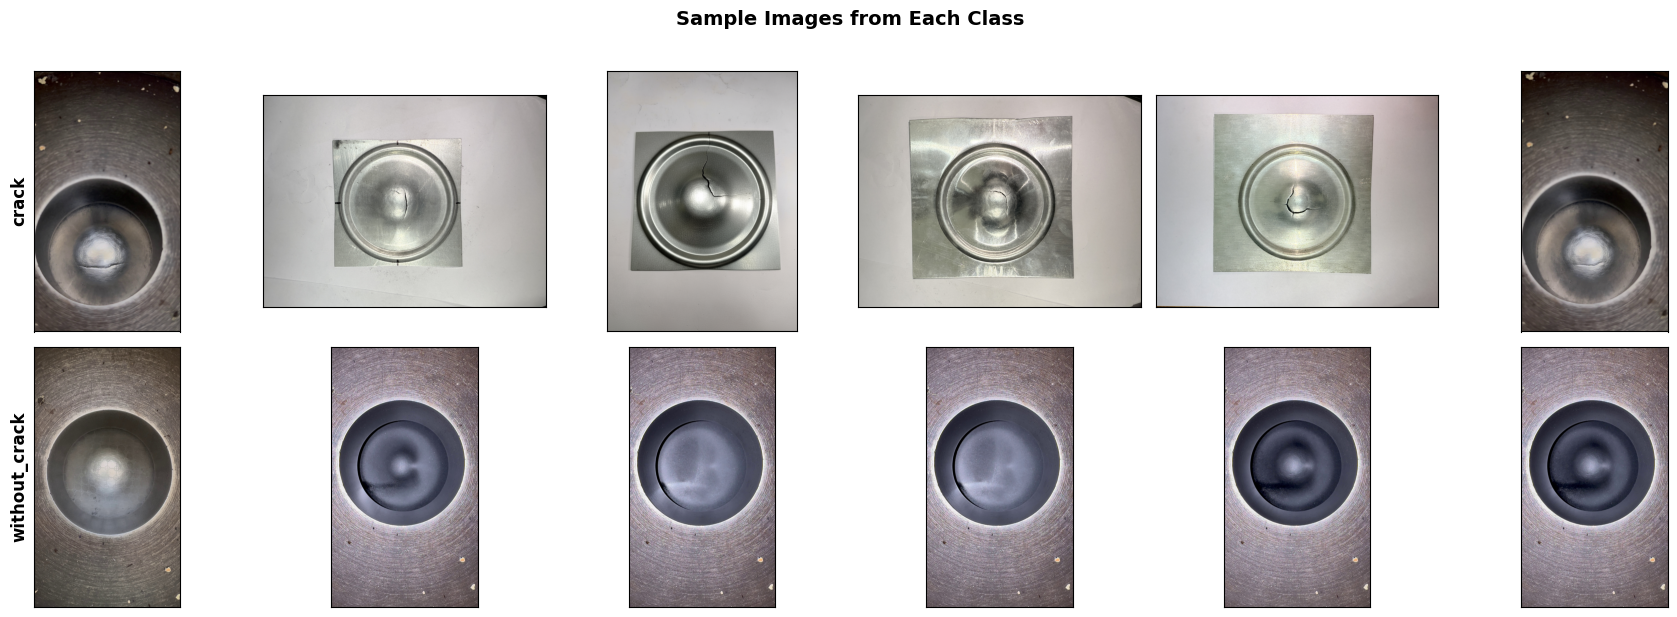

In [4]:
def visualize_samples(all_images, n_samples=12, seed=42):
    """Visualize random samples from each class."""
    random.seed(seed)
    
    # Group by class
    by_class = {}
    for img_path, label in all_images:
        if label not in by_class:
            by_class[label] = []
        by_class[label].append(img_path)
    
    n_classes = len(by_class)
    samples_per_class = n_samples // n_classes
    
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=(3*samples_per_class, 3*n_classes))
    if n_classes == 1:
        axes = [axes]
    
    for row, (class_name, images) in enumerate(sorted(by_class.items())):
        sampled = random.sample(images, min(samples_per_class, len(images)))
        for col, img_path in enumerate(sampled):
            ax = axes[row][col] if n_classes > 1 else axes[col]
            img = Image.open(img_path).convert('RGB')
            ax.imshow(img)
            if col == 0:
                ax.set_ylabel(class_name, fontsize=12, fontweight='bold')
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

if result:
    visualize_samples(all_images, n_samples=12)

In [5]:
def prepare_yolo_dataset(data_dir, output_dir, val_split=0.15, test_split=0.10, seed=42):
    """
    Prepare dataset in YOLOv8 classification format:
    output_dir/
        train/
            class1/
            class2/
        val/
            class1/
            class2/
        test/
            class1/
            class2/
    """
    data_dir = Path(data_dir)
    output_dir = Path(output_dir) / 'yolo_dataset'
    
    # Remove existing if present
    if output_dir.exists():
        shutil.rmtree(output_dir)
    
    # Create directories
    for split in ['train', 'val', 'test']:
        (output_dir / split).mkdir(parents=True, exist_ok=True)
    
    print(f"📁 Creating YOLOv8 dataset structure at: {output_dir}")
    
    # Process each class
    for class_dir in sorted(data_dir.iterdir()):
        if not class_dir.is_dir():
            continue
        
        class_name = class_dir.name
        
        # Get all images
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg')) + \
                 list(class_dir.glob('*.png')) + list(class_dir.glob('*.JPG')) + \
                 list(class_dir.glob('*.JPEG')) + list(class_dir.glob('*.PNG'))
        
        if len(images) == 0:
            continue
        
        # Split data
        train_imgs, temp_imgs = train_test_split(
            images, test_size=(val_split + test_split), random_state=seed, shuffle=True
        )
        
        # Split remaining into val and test
        relative_test = test_split / (val_split + test_split)
        val_imgs, test_imgs = train_test_split(
            temp_imgs, test_size=relative_test, random_state=seed, shuffle=True
        )
        
        # Create class subdirectories and copy images
        for split, split_imgs in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
            split_class_dir = output_dir / split / class_name
            split_class_dir.mkdir(parents=True, exist_ok=True)
            
            for img_path in split_imgs:
                shutil.copy2(img_path, split_class_dir / img_path.name)
        
        print(f"  • {class_name}: train={len(train_imgs)}, val={len(val_imgs)}, test={len(test_imgs)}")
    
    print(f"\n✅ Dataset prepared at: {output_dir}")
    return output_dir

# Prepare the dataset
if result:
    YOLO_DATA_DIR = prepare_yolo_dataset(
        DATA_DIR, OUTPUT_DIR,
        val_split=CONFIG['val_split'],
        test_split=CONFIG['test_split'],
        seed=SEED
    )

📁 Creating YOLOv8 dataset structure at: output\yolo_dataset
  • crack: train=427, val=85, test=58
  • without_crack: train=430, val=86, test=58

✅ Dataset prepared at: output\yolo_dataset


## 4️⃣ Model Training

In [6]:
def train_yolov8_classifier(data_dir, config, output_dir):
    """
    Train YOLOv8 classification model.
    """
    print("\n" + "="*60)
    print(f"🚀 Training {config['model']}")
    print("="*60)
    
    # Load pretrained model
    model = YOLO(f"{config['model']}.pt")
    
    # Train the model
    results = model.train(
        data=str(data_dir),
        epochs=config['epochs'],
        imgsz=config['img_size'],
        batch=config['batch_size'],
        patience=config['patience'],
        
        # Learning rate
        lr0=config['lr0'],
        lrf=config['lrf'],
        
        # Augmentation parameters
        augment=config['augment'],
        hsv_h=config['hsv_h'],
        hsv_s=config['hsv_s'],
        hsv_v=config['hsv_v'],
        degrees=config['degrees'],
        translate=config['translate'],
        scale=config['scale'],
        shear=config['shear'],
        flipud=config['flipud'],
        fliplr=config['fliplr'],
        mosaic=config['mosaic'],
        mixup=config['mixup'],
        erasing=config['erasing'],
        
        # Training settings
        optimizer='AdamW',
        cos_lr=True,          # Cosine LR scheduler
        warmup_epochs=3,
        warmup_momentum=0.8,
        weight_decay=0.0005,
        
        # Output
        project=str(output_dir),
        name=f'{config["model"]}_training',
        exist_ok=True,
        
        # Hardware
        device='0' if os.path.exists('/dev/nvidia0') else 'cpu',  # Auto-detect GPU
        workers=4,
        
        # Verbosity
        verbose=True,
        plots=True,
    )
    
    return model, results

# Train the model
if result:
    model, train_results = train_yolov8_classifier(YOLO_DATA_DIR, CONFIG, OUTPUT_DIR)


🚀 Training yolov8n-cls
Ultralytics 8.4.5  Python-3.11.9 torch-2.9.1+cpu CPU (12th Gen Intel Core i5-12500H)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=output\yolo_dataset, degrees=10.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.2, exist_ok=True, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=0.0, multi_scale=0.0, name=yolov8n-cls_training, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patien

KeyboardInterrupt: 

In [ ]:
# Display training results
def display_training_results(output_dir, model_name):
    """Display training curves and metrics."""
    results_dir = Path(output_dir) / f'{model_name}_training'
    
    # Find result images
    result_images = ['results.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png']
    
    for img_name in result_images:
        img_path = results_dir / img_name
        if img_path.exists():
            print(f"\n📊 {img_name}:")
            img = Image.open(img_path)
            plt.figure(figsize=(12, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.title(img_name.replace('.png', '').replace('_', ' ').title(), fontsize=14)
            plt.tight_layout()
            plt.show()

if result:
    display_training_results(OUTPUT_DIR, CONFIG['model'])

## 5️⃣ Model Evaluation on Test Set

In [ ]:
def evaluate_model(model, test_dir, class_names, output_dir):
    """
    Comprehensive evaluation on test set.
    """
    print("\n" + "="*60)
    print("📊 Evaluating Model on Test Set")
    print("="*60)
    
    test_dir = Path(test_dir)
    
    # Collect all test images and their true labels
    all_images = []
    all_true_labels = []
    
    for class_idx, class_name in enumerate(sorted(class_names)):
        class_dir = test_dir / class_name
        if class_dir.exists():
            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    all_images.append(img_path)
                    all_true_labels.append(class_idx)
    
    print(f"Test images: {len(all_images)}")
    
    # Run predictions
    all_preds = []
    all_probs = []
    
    print("Running predictions...")
    for img_path in tqdm(all_images):
        result = model.predict(str(img_path), verbose=False)
        pred_class = result[0].probs.top1
        pred_probs = result[0].probs.data.cpu().numpy()
        all_preds.append(pred_class)
        all_probs.append(pred_probs)
    
    all_preds = np.array(all_preds)
    all_true_labels = np.array(all_true_labels)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    accuracy = accuracy_score(all_true_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_preds, average='weighted'
    )
    
    print(f"\n{'='*40}")
    print(f"🎯 OVERALL METRICS")
    print(f"{'='*40}")
    print(f"  Accuracy:  {accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  F1-Score:  {f1*100:.2f}%")
    
    if accuracy >= 0.92:
        print(f"\n✅ TARGET ACHIEVED! Accuracy > 92%")
    else:
        print(f"\n⚠️ Target not reached yet. Consider:")
        print(f"   - Training longer (more epochs)")
        print(f"   - Using a larger model (yolov8s-cls, yolov8m-cls)")
        print(f"   - More data augmentation")
        print(f"   - Adjusting learning rate")
    
    # Classification report
    print(f"\n📋 Classification Report:")
    print(classification_report(all_true_labels, all_preds, target_names=sorted(class_names)))
    
    # Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(class_names),
                yticklabels=sorted(class_names))
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(f'Confusion Matrix (Accuracy: {accuracy*100:.2f}%)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_dir / 'test_confusion_matrix.png', dpi=150)
    plt.show()
    
    # Normalized Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=sorted(class_names),
                yticklabels=sorted(class_names))
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(output_dir / 'test_confusion_matrix_normalized.png', dpi=150)
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'true_labels': all_true_labels,
        'probabilities': all_probs,
        'image_paths': all_images
    }

# Evaluate model
if result:
    test_dir = YOLO_DATA_DIR / 'test'
    eval_results = evaluate_model(model, test_dir, class_names, OUTPUT_DIR)

## 6️⃣ Visualize Predictions

In [ ]:
def visualize_predictions(eval_results, class_names, n_samples=16, seed=42):
    """
    Visualize correct and incorrect predictions.
    """
    random.seed(seed)
    
    preds = eval_results['predictions']
    true_labels = eval_results['true_labels']
    probs = eval_results['probabilities']
    paths = eval_results['image_paths']
    
    sorted_classes = sorted(class_names)
    
    # Find correct and incorrect predictions
    correct_idx = np.where(preds == true_labels)[0]
    incorrect_idx = np.where(preds != true_labels)[0]
    
    print(f"Correct predictions: {len(correct_idx)}")
    print(f"Incorrect predictions: {len(incorrect_idx)}")
    
    # Plot correct predictions
    n_show = min(n_samples, len(correct_idx))
    if n_show > 0:
        sample_idx = random.sample(list(correct_idx), n_show)
        cols = min(4, n_show)
        rows = (n_show + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axes = axes.flat if n_show > 1 else [axes]
        
        for ax, idx in zip(axes, sample_idx):
            img = Image.open(paths[idx]).convert('RGB')
            ax.imshow(img)
            true_name = sorted_classes[true_labels[idx]]
            prob = probs[idx].max() * 100
            ax.set_title(f'✅ {true_name}\n({prob:.1f}% conf)', fontsize=10, color='green')
            ax.axis('off')
        
        # Hide empty subplots
        for ax in axes[n_show:]:
            ax.set_visible(False)
        
        plt.suptitle('Correct Predictions', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'correct_predictions.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot incorrect predictions
    n_show = min(n_samples, len(incorrect_idx))
    if n_show > 0:
        sample_idx = list(incorrect_idx)[:n_show]  # Show first N mistakes
        cols = min(4, n_show)
        rows = (n_show + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axes = axes.flat if n_show > 1 else [axes]
        
        for ax, idx in zip(axes, sample_idx):
            img = Image.open(paths[idx]).convert('RGB')
            ax.imshow(img)
            true_name = sorted_classes[true_labels[idx]]
            pred_name = sorted_classes[preds[idx]]
            prob = probs[idx].max() * 100
            ax.set_title(f'❌ True: {true_name}\nPred: {pred_name} ({prob:.1f}%)',
                        fontsize=10, color='red')
            ax.axis('off')
        
        # Hide empty subplots
        for ax in axes[n_show:]:
            ax.set_visible(False)
        
        plt.suptitle('Incorrect Predictions (Misclassifications)', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'incorrect_predictions.png', dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("🎉 Perfect! No misclassifications on test set!")

if result:
    visualize_predictions(eval_results, class_names)

## 7️⃣ Try Different Models for Higher Accuracy

In [ ]:
# If accuracy is below 92%, try a larger model
def train_multiple_models(data_dir, output_dir):
    """
    Train multiple YOLOv8 models and compare results.
    """
    models_to_try = [
        ('yolov8n-cls', 'Nano (fastest)'),
        ('yolov8s-cls', 'Small (balanced)'),
        ('yolov8m-cls', 'Medium (more accurate)'),
    ]
    
    results_comparison = []
    
    for model_name, description in models_to_try:
        print(f"\n{'='*60}")
        print(f"🚀 Training {model_name} - {description}")
        print(f"{'='*60}")
        
        # Update config
        config = CONFIG.copy()
        config['model'] = model_name
        
        # Train
        model = YOLO(f"{model_name}.pt")
        model.train(
            data=str(data_dir),
            epochs=config['epochs'],
            imgsz=config['img_size'],
            batch=config['batch_size'],
            patience=config['patience'],
            lr0=config['lr0'],
            lrf=config['lrf'],
            augment=config['augment'],
            optimizer='AdamW',
            cos_lr=True,
            project=str(output_dir),
            name=f'{model_name}_training',
            exist_ok=True,
            verbose=True,
        )
        
        # Evaluate on test
        test_dir = data_dir / 'test'
        eval_result = evaluate_model(model, test_dir, class_names, output_dir)
        
        results_comparison.append({
            'model': model_name,
            'description': description,
            'accuracy': eval_result['accuracy'],
            'precision': eval_result['precision'],
            'recall': eval_result['recall'],
            'f1': eval_result['f1']
        })
        
        # Stop if target reached
        if eval_result['accuracy'] >= 0.92:
            print(f"\n✅ Target accuracy achieved with {model_name}!")
            break
    
    # Print comparison
    print("\n" + "="*60)
    print("📊 MODEL COMPARISON RESULTS")
    print("="*60)
    df_results = pd.DataFrame(results_comparison)
    print(df_results.to_string(index=False))
    
    # Find best model
    best = max(results_comparison, key=lambda x: x['accuracy'])
    print(f"\n🏆 Best Model: {best['model']} with {best['accuracy']*100:.2f}% accuracy")
    
    return results_comparison

# Uncomment to train multiple models:
# if result and eval_results['accuracy'] < 0.92:
#     comparison_results = train_multiple_models(YOLO_DATA_DIR, OUTPUT_DIR)

## 8️⃣ Export & Save Best Model

In [ ]:
def export_model(model, output_dir, formats=['onnx', 'torchscript']):
    """
    Export trained model to various formats.
    """
    print("\n📦 Exporting model...")
    
    for fmt in formats:
        try:
            print(f"  Exporting to {fmt.upper()}...")
            exported = model.export(format=fmt)
            print(f"  ✅ Exported: {exported}")
        except Exception as e:
            print(f"  ❌ Failed to export {fmt}: {e}")
    
    print("\n✅ Model export complete!")

# Export the model (uncomment to use)
# if result:
#     export_model(model, OUTPUT_DIR, formats=['onnx'])

In [ ]:
# Save the best model weights
if result:
    best_model_path = OUTPUT_DIR / f'{CONFIG["model"]}_training' / 'weights' / 'best.pt'
    if best_model_path.exists():
        # Copy to main output directory
        shutil.copy(best_model_path, OUTPUT_DIR / 'best_crack_detector.pt')
        print(f"✅ Best model saved to: {OUTPUT_DIR / 'best_crack_detector.pt'}")
    else:
        print(f"⚠️ Best model not found at expected path: {best_model_path}")

## 9️⃣ Inference on New Images

In [ ]:
def predict_single_image(model, image_path, class_names):
    """
    Run prediction on a single image.
    """
    result = model.predict(str(image_path), verbose=False)
    
    sorted_classes = sorted(class_names)
    pred_idx = result[0].probs.top1
    pred_prob = result[0].probs.top1conf.item()
    pred_class = sorted_classes[pred_idx]
    
    # Display
    img = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    color = 'green' if pred_prob > 0.7 else 'orange'
    plt.title(f'Prediction: {pred_class}\nConfidence: {pred_prob*100:.1f}%',
              fontsize=14, color=color, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return pred_class, pred_prob

def predict_folder(model, folder_path, class_names):
    """
    Run predictions on all images in a folder.
    """
    folder = Path(folder_path)
    image_files = list(folder.glob('*.jpg')) + list(folder.glob('*.jpeg')) + \
                  list(folder.glob('*.png'))
    
    if len(image_files) == 0:
        print(f"No images found in {folder}")
        return None
    
    sorted_classes = sorted(class_names)
    results = []
    
    for img_path in tqdm(image_files, desc="Predicting"):
        result = model.predict(str(img_path), verbose=False)
        pred_idx = result[0].probs.top1
        pred_prob = result[0].probs.top1conf.item()
        pred_class = sorted_classes[pred_idx]
        
        results.append({
            'image': img_path.name,
            'path': str(img_path),
            'prediction': pred_class,
            'confidence': pred_prob
        })
    
    df_results = pd.DataFrame(results)
    print(f"\n📊 Predictions Summary:")
    print(df_results['prediction'].value_counts())
    
    return df_results

# Example usage:
# predict_single_image(model, 'path/to/image.jpg', class_names)
# df_predictions = predict_folder(model, 'path/to/folder', class_names)

## 🔟 Summary & Next Steps

In [ ]:
print("""
╔══════════════════════════════════════════════════════════════╗
║              🎯 CRACK DETECTION PROJECT SUMMARY              ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  Model Used:     YOLOv8 Classification                       ║
║  Target:         >92% Accuracy                               ║
║                                                              ║
║  📋 TIPS FOR HIGHER ACCURACY:                                ║
║                                                              ║
║  1. Use larger model:                                        ║
║     • yolov8s-cls (Small) - Good balance                     ║
║     • yolov8m-cls (Medium) - Better accuracy                 ║
║     • yolov8l-cls (Large) - Best accuracy                    ║
║                                                              ║
║  2. Train longer:                                            ║
║     • Increase epochs to 100+                                ║
║     • Use patience=15-20 for early stopping                  ║
║                                                              ║
║  3. More augmentation:                                       ║
║     • Increase mixup, erasing, color jitter                  ║
║     • Add custom augmentations with Albumentations           ║
║                                                              ║
║  4. Learning rate tuning:                                    ║
║     • Try lr0=0.001 for fine-tuning                          ║
║     • Use warmup_epochs=5                                    ║
║                                                              ║
║  5. Ensemble models:                                         ║
║     • Train 3-5 models, average predictions                  ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
""")

if result:
    print(f"\n📊 Your Results:")
    print(f"   • Accuracy:  {eval_results['accuracy']*100:.2f}%")
    print(f"   • Precision: {eval_results['precision']*100:.2f}%")
    print(f"   • Recall:    {eval_results['recall']*100:.2f}%")
    print(f"   • F1-Score:  {eval_results['f1']*100:.2f}%")
    
    if eval_results['accuracy'] >= 0.92:
        print("\n🎉 CONGRATULATIONS! Target accuracy achieved!")
    else:
        print(f"\n📈 Need {(0.92 - eval_results['accuracy'])*100:.2f}% more to reach target.")